In [1]:
import json
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import emoji

In [2]:
data = []
with open('tweet/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line)) 
f.close()

emotion = pd.read_csv('tweet/emotion.csv')
data_identification = pd.read_csv('tweet/data_identification.csv')

df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')

train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

train_data = train_data.merge(emotion, on='tweet_id', how='left')
train_data

,tweet_id,hashtags,text,identification,emotion
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,0x1d755c,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,train,anticipation
...,...,...,...,...,...
1455558,0x321566,"[NoWonder, Happy]",I'm SO HAPPY!!! #NoWonder the name of this sho...,train,joy
1455559,0x38959e,[],In every circumtance I'd like to be thankful t...,train,joy
1455560,0x2cbca6,[blessyou],there's currently two girls walking around the...,train,joy
1455561,0x24faed,[],"Ah, corporate life, where you can date <LH> us...",train,joy


In [3]:
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)
train_data

,tweet_id,hashtags,text,identification,emotion
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,0x1d755c,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,train,anticipation
...,...,...,...,...,...
1455558,0x321566,"[NoWonder, Happy]",I'm SO HAPPY!!! #NoWonder the name of this sho...,train,joy
1455559,0x38959e,[],In every circumtance I'd like to be thankful t...,train,joy
1455560,0x2cbca6,[blessyou],there's currently two girls walking around the...,train,joy
1455561,0x24faed,[],"Ah, corporate life, where you can date <LH> us...",train,joy


In [4]:
train_data_sample = train_data.sample(frac=0.3, random_state=42)
train_data_sample.to_pickle("train_dsample.pkl")
train_df = pd.read_pickle("train_dsample.pkl")

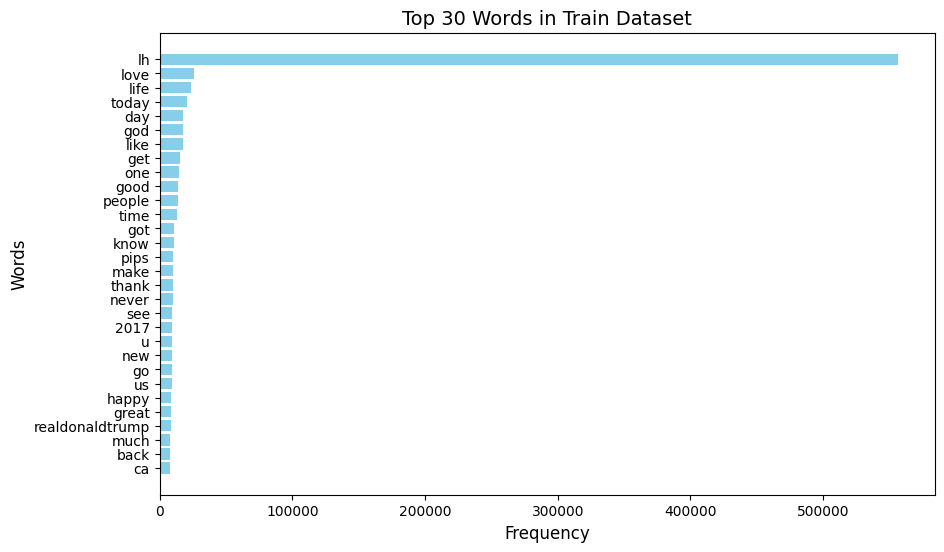

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

def tokenize_and_count(text_list):
    stop_words = set(stopwords.words('english'))
    words = []
    for text in text_list:
        tokens = word_tokenize(text.lower())
        words.extend([word for word in tokens if word.isalnum() and word not in stop_words])
    return Counter(words)

# Get word frequencies for train
train_word_counts = tokenize_and_count(train_data_sample['text'])

# Extract the top 30 words for each dataset
top_train_words = train_word_counts.most_common(30)

# Plot the word frequencies
def plot_word_frequencies(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.show()

# Plot for train dataset
plot_word_frequencies(top_train_words, "Top 30 Words in Train Dataset")

emotion
joy             154445
anticipation     74110
trust            61615
sadness          57586
disgust          41614
fear             19076
surprise         14240
anger            12069
Name: count, dtype: int64


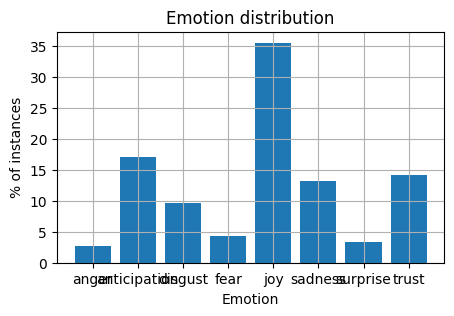

In [6]:
train_df.groupby(['emotion']).count()['text']
print(train_df['emotion'].value_counts())

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

In [6]:
from sklearn.utils import resample

# 分群處理
minority_classes = train_df['emotion'].value_counts().min()
balanced_df = pd.concat([
    resample(train_df[train_df['emotion'] == emotion], 
             replace=False, # 不重複抽樣
             n_samples=minority_classes, 
             random_state=42)
    for emotion in train_df['emotion'].unique()
])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['emotion'].value_counts())

emotion
disgust         12069
anticipation    12069
sadness         12069
fear            12069
anger           12069
joy             12069
trust           12069
surprise        12069
Name: count, dtype: int64


In [7]:
emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]'
}

def preprocess_text(text):
    # 將定義的表情符號替換為對應的關鍵詞
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    # 移除其餘的表情符號
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'http\S+', '', text)
    text = text.replace('<LH>', '')
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'@\w+', '', text)
    text = ' '.join(text.split())
    text = text.lower()  
    text = text.strip()
    return text

balanced_df['processed_text'] = balanced_df['text'].apply(preprocess_text)
balanced_df

,tweet_id,hashtags,text,identification,emotion,processed_text
0,0x32cbfb,"[WeChoose, WheresTheFunding]",#WeChoose Teachers say they want cultural comp...,train,disgust,wechoose teachers say they want cultural compe...
1,0x35fcdc,[shame],@ProudResister @jacksnowknows the fact that he...,train,disgust,proudresister jacksnowknows the fact that he d...
2,0x23c1d0,[Life],73 The moments in your life are only once #Lif...,train,anticipation,73 the moments in your life are only once life...
3,0x24bcbb,[Exams],Exam sucks...!!! #Exams <LH>,train,sadness,exam sucks exams
4,0x2fb40d,[],there’s no way in hell im playing the evil wit...,train,fear,theres no way in hell im playing the evil with...
...,...,...,...,...,...,...
96547,0x24436b,[],@CCharities_GHTX You are welcome! Have a <LH> ...,train,joy,ccharitiesghtx you are welcome have a week
96548,0x2cbf58,[],@Michell76657729 Thank you VERY much for the f...,train,anticipation,michell76657729 thank you very much for the fo...
96549,0x38687a,[],@Foxnews you should be fucking <LH> of your se...,train,sadness,foxnews you should be fucking of your self eve...
96550,0x2c72d1,"[dick, gaythoughts]",Real men care about the size of your heart. No...,train,joy,real men care about the size of your heart not...


In [8]:
# 创建标签编码器
label_encoder = LabelEncoder()
balanced_df['emotion_encoded'] = label_encoder.fit_transform(balanced_df['emotion'])

# 获取类别映射
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
inverse_label_map = {v: k for k, v in label_map.items()}

balanced_df

,tweet_id,hashtags,text,identification,emotion,processed_text,emotion_encoded
0,0x32cbfb,"[WeChoose, WheresTheFunding]",#WeChoose Teachers say they want cultural comp...,train,disgust,wechoose teachers say they want cultural compe...,2
1,0x35fcdc,[shame],@ProudResister @jacksnowknows the fact that he...,train,disgust,proudresister jacksnowknows the fact that he d...,2
2,0x23c1d0,[Life],73 The moments in your life are only once #Lif...,train,anticipation,73 the moments in your life are only once life...,1
3,0x24bcbb,[Exams],Exam sucks...!!! #Exams <LH>,train,sadness,exam sucks exams,5
4,0x2fb40d,[],there’s no way in hell im playing the evil wit...,train,fear,theres no way in hell im playing the evil with...,3
...,...,...,...,...,...,...,...
96547,0x24436b,[],@CCharities_GHTX You are welcome! Have a <LH> ...,train,joy,ccharitiesghtx you are welcome have a week,4
96548,0x2cbf58,[],@Michell76657729 Thank you VERY much for the f...,train,anticipation,michell76657729 thank you very much for the fo...,1
96549,0x38687a,[],@Foxnews you should be fucking <LH> of your se...,train,sadness,foxnews you should be fucking of your self eve...,5
96550,0x2c72d1,"[dick, gaythoughts]",Real men care about the size of your heart. No...,train,joy,real men care about the size of your heart not...,4


In [9]:
# Word2Vec 訓練與文本向量化
from gensim.models import Word2Vec

def train_word2vec(texts, vector_size=100, window=5, min_count=1):
    tokenized_texts = [text.split() for text in texts]
    return Word2Vec(sentences=tokenized_texts, vector_size=vector_size, 
                    window=window, min_count=min_count, workers=4)

def text_to_vector(text, word2vec_model, max_length=50):
    words = text.split()
    vector = np.zeros((max_length, word2vec_model.vector_size))
    for i, word in enumerate(words[:max_length]):
        if word in word2vec_model.wv.key_to_index:
            vector[i] = word2vec_model.wv[word]
    return vector

# Word2Vec模型
word2vec_model = train_word2vec(balanced_df['processed_text'])
w2v_features = np.stack(balanced_df['processed_text'].apply(lambda x: text_to_vector(x, word2vec_model)))

In [18]:
def process_hashtags(hashtags):
    if isinstance(hashtags, list):
        return ' '.join(hashtags)
    try:
        hashtags = eval(hashtags)
        return ' '.join(hashtags)
    except:
        return '[no_hashtag]'

df['hashtag_text'] = df['hashtags'].apply(process_hashtags)

# TF-IDF
balanced_df['hashtag_text'] = balanced_df['hashtags'].apply(process_hashtags)
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_vectorizer.fit(balanced_df['hashtag_text'])
hashtag_tfidf = tfidf_vectorizer.transform(balanced_df['hashtag_text']).toarray()

In [19]:
# 合併特徵
combined_features = np.hstack((
    w2v_features.reshape(w2v_features.shape[0], -1), 
    hashtag_tfidf
))

In [20]:
# 數據集類
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [21]:
# 模型定義
class EmotionLSTMClassifier(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_classes, max_length=50):
        super(EmotionLSTMClassifier, self).__init__()
        
        # 特徵融合層
        self.feature_fusion = nn.Linear(input_size, embedding_dim)
        
        # LSTM層
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            num_layers=2,  # 增加LSTM層數
            batch_first=True,
            dropout=0.3,
            bidirectional=True  # 使用雙向LSTM
        )
        
        # 全連接層
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),  # 雙向LSTM輸出需要乘2
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # 特徵融合
        x = self.feature_fusion(x)
        
        # 為LSTM增加序列維度
        x_reshaped = x.unsqueeze(1).repeat(1, 50, 1)
        
        # LSTM處理
        lstm_out, (hidden, cell) = self.lstm(x_reshaped)
        
        # 取最後一個時間步的輸出
        last_time_step = lstm_out[:, -1, :]
        
        # 全連接層分類
        output = self.fc(last_time_step)
        
        return output

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20):
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # 訓練階段
        model.train()
        train_loss = 0
        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 驗證階段
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Accuracy: {100 * correct / total:.2f}%")
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pth')
    
    return model

In [25]:
# 數據分割
X_train, X_val, y_train, y_val = train_test_split(
    combined_features, 
    balanced_df['emotion_encoded'], 
    test_size=0.2, 
    random_state=42
)

# 數據加載器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = EmotionDataset(X_train, y_train.to_numpy())
val_dataset = EmotionDataset(X_val, y_val.to_numpy())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# 模型初始化
model = EmotionLSTMClassifier(
    input_size=combined_features.shape[1],
    embedding_dim=128,
    hidden_size=64,
    num_classes=len(label_encoder.classes_)
).to(device)

# 損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 訓練模型
trained_model = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device
)

Epoch 1/20
Train Loss: 1.9315
Val Loss: 1.8481
Val Accuracy: 27.75%
Epoch 2/20
Train Loss: 1.8652
Val Loss: 1.8483
Val Accuracy: 27.55%
Epoch 3/20
Train Loss: 1.8480
Val Loss: 1.8412
Val Accuracy: 28.04%
Epoch 4/20
Train Loss: 1.8405
Val Loss: 1.8351
Val Accuracy: 28.89%
Epoch 5/20
Train Loss: 1.8344
Val Loss: 1.8287
Val Accuracy: 29.05%
Epoch 6/20
Train Loss: 1.8195
Val Loss: 1.8164
Val Accuracy: 29.62%
Epoch 7/20
Train Loss: 1.8153
Val Loss: 1.8170
Val Accuracy: 29.68%
Epoch 8/20
Train Loss: 1.8121
Val Loss: 1.8164
Val Accuracy: 29.78%
Epoch 9/20
Train Loss: 1.8078
Val Loss: 1.8173
Val Accuracy: 29.87%
Epoch 10/20
Train Loss: 1.8062
Val Loss: 1.8216
Val Accuracy: 29.77%
Epoch 11/20
Train Loss: 1.8029
Val Loss: 1.8190
Val Accuracy: 29.58%
Epoch 12/20
Train Loss: 1.8006
Val Loss: 1.8146
Val Accuracy: 29.78%
Epoch 13/20
Train Loss: 1.7912
Val Loss: 1.8235
Val Accuracy: 29.19%
Epoch 14/20
Train Loss: 1.7965
Val Loss: 1.8190
Val Accuracy: 29.77%
Epoch 15/20
Train Loss: 1.7982
Val Loss: 1.

Classification Report:
              precision    recall  f1-score   support

       anger       0.27      0.38      0.31      2361
anticipation       0.42      0.41      0.41      2445
     disgust       0.23      0.38      0.29      2428
        fear       0.34      0.34      0.34      2438
         joy       0.30      0.28      0.29      2455
     sadness       0.39      0.15      0.21      2355
    surprise       0.26      0.14      0.19      2413
       trust       0.31      0.33      0.32      2416

    accuracy                           0.30     19311
   macro avg       0.32      0.30      0.30     19311
weighted avg       0.32      0.30      0.30     19311



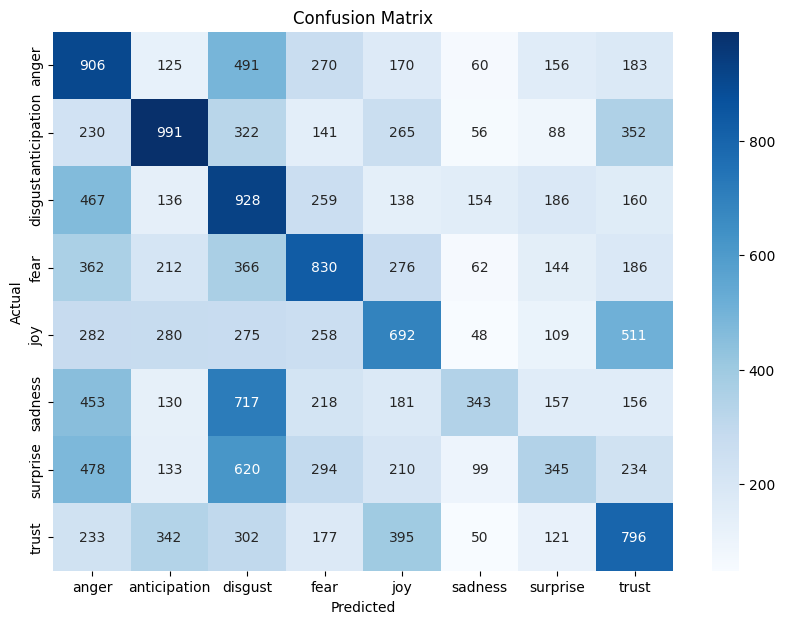

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 混淆矩陣與分類報告
def evaluate_model(model, loader, label_map, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_features, batch_labels in loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(batch_labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_map.values()))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# 評估模型
evaluate_model(trained_model, val_loader, inverse_label_map, device)


In [33]:
# 從原始資料中提取測試集
test_df = df[df['identification'] == 'test'].copy()  # 創建副本
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

test_w2v_features = np.stack(test_df['processed_text'].apply(lambda x: text_to_vector(x, word2vec_model)))
test_hashtag_tfidf = tfidf_vectorizer.transform(test_df['hashtag_text']).toarray()

# 合併測試特徵
test_features = np.hstack((
    test_w2v_features.reshape(test_w2v_features.shape[0], -1),
    test_hashtag_tfidf
))

# 提取測試集的 tweet_id
test_ids = test_df['tweet_id'].values

# 模型預測
test_features_tensor = torch.FloatTensor(test_features).to(device)
model.eval()
with torch.no_grad():
    test_outputs = model(test_features_tensor)
    test_predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()

# 將預測結果解碼為情緒標籤
test_emotions = [inverse_label_map_test[pred] for pred in test_predictions]

# 生成提交檔案
submission = pd.DataFrame({
    'id': test_ids,
    'emotion': test_emotions
})
submission.to_csv('submission_lstm.csv', index=False)

MemoryError: Unable to allocate 15.3 GiB for an array with shape (411972, 50, 100) and data type float64

In [30]:
test_df

,tweet_id,hashtags,text,identification,hashtag_text,processed_text
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",test,bibleverse,confident of your obedience i write to you kno...
4,0x2de201,[],"""Trust is not the same as faith. A friend is s...",test,,trust is not the same as faith a friend is som...
9,0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfi...,test,materialism money possessions,when do you have enough when are you satisfied...
30,0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #...",test,GodsPlan GodsWork,god woke you up now chase the day godsplan god...
33,0x26289a,[],"In these tough times, who do YOU turn to as yo...",test,,in these tough times who do you turn to as you...
...,...,...,...,...,...,...
1867525,0x2913b4,[],"""For this is the message that ye heard from th...",test,,for this is the message that ye heard from the...
1867529,0x2a980e,[],"""There is a lad here, which hath five barley l...",test,,there is a lad here which hath five barley loa...
1867530,0x316b80,"[mixedfeeling, butimTHATperson]",When you buy the last 2 tickets remaining for ...,test,mixedfeeling butimTHATperson,when you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,[],I swear all this hard work gone pay off one da...,test,,i swear all this hard work gone pay off one day


In [17]:
trained_model = train_model(
    train_features, 
    val_features, 
    train_labels, 
    val_labels, 
    num_classes=len(np.unique(balanced_df['emotion_encoded']))
)

RuntimeError: expected scalar type Long but found Int

In [21]:
# 測試集處理
test_data['processed_text'] = test_data['text'].apply(preprocess_text)
test_data['hashtag_text'] = test_data['hashtags'].apply(process_hashtags)
test_w2v_features = np.stack(test_data['processed_text'].apply(lambda x: text_to_vector(x, word2vec_model)))
test_hashtag_features = tfidf_vectorizer.transform(test_data['hashtag_text']).toarray()
#test_hashtag_count = test_data['hashtags'].apply(lambda x: len(eval(x)) if isinstance(x, str) and x != 'nan' else 0).values.reshape(-1, 1)
test_combined_features = np.hstack((test_w2v_features.reshape(test_w2v_features.shape[0], -1), 
                                    test_hashtag_features))

# test_dataset = EmotionDataset(test_combined_features, [None]*len(test_combined_features))
# test_loader = DataLoader(test_dataset, batch_size=64)

C:\Users\t1070\AppData\Local\Temp\ipykernel_24600\2586024506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['processed_text'] = test_data['text'].apply(preprocess_text)
C:\Users\t1070\AppData\Local\Temp\ipykernel_24600\2586024506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['hashtag_text'] = test_data['hashtags'].apply(process_hashtags)


In [ ]:
# 創建測試集數據集
class TestDataset(Dataset):
    def __init__(self, features):
        self.features = features
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx])

test_dataset = TestDataset(test_combined_features)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:

def evaluate_model(model, val_loader, device, label_encoder):
    """
    模型評估函數，生成混淆矩陣和分類報告
    
    Args:
    - model: 訓練好的模型
    - val_loader: 驗證集數據加載器
    - device: 設備（CPU/GPU）
    - label_encoder: 標籤編碼字典
    
    Returns:
    - confusion matrix
    - classification report
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 反向映射標籤
    inverse_label_map = {idx: label for label, idx in label_encoder.items()}
    all_preds_labels = [inverse_label_map[pred] for pred in all_preds]
    all_true_labels = [inverse_label_map[label] for label in all_labels]
    
    # 混淆矩陣
    cm = confusion_matrix(all_true_labels, all_preds_labels, labels=list(label_encoder.keys()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_encoder.keys()), yticklabels=list(label_encoder.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # 分類報告
    report = classification_report(all_true_labels, all_preds_labels)
    print("Classification Report:")
    print(report)
    
    return cm, report
# # 預測生成提交文件
# trained_model.eval()
# test_predictions = []

# with torch.no_grad():
#     for features in test_loader:
#         features = features.to(device)
#         outputs = trained_model({'text': features[:, :50], 'hashtag_vector': features[:, 50:]})
#         _, predicted = torch.max(outputs.data, 1)
#         test_predictions.extend(predicted.cpu().numpy())
#     # for texts, _ in test_loader:
#     #     outputs = model(texts)
#     #     _, predicted = torch.max(outputs.data, 1)
#     #     predictions.extend(predicted.cpu().numpy())

In [ ]:
# 反向映射情緒類別 
predicted_emotions = [val_dataset.inverse_label_map[pred] for pred in test_predictions]

# 生成提交文件
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': predicted_emotions
})
submission.to_csv('emotion_prediction_submission.csv', index=False)
print("提交文件已生成！")

In [13]:
# 訓練 Word2Vec 模型
word2vec_model = train_word2vec(balanced_df['processed_text'])

# 文本向量化
def text_to_vector(text, word2vec_model, max_length=50):
    words = text.split()
    vector = np.zeros((max_length, word2vec_model.vector_size))
    for i, word in enumerate(words[:max_length]):
        if word in word2vec_model.wv.key_to_index:
            vector[i] = word2vec_model.wv[word]
    return vector

# 將平衡數據集的文本轉換為向量
w2v_features = np.stack(balanced_df['processed_text'].apply(lambda x: text_to_vector(x, word2vec_model)))

# # Word2Vec訓練
# def train_word2vec(texts, vector_size=100, window=5, min_count=1):
#     from gensim.models import Word2Vec
    
#     # 分詞
#     tokenized_texts = [text.split() for text in texts]
    
#     # 訓練Word2Vec模型
#     model = Word2Vec(
#         sentences=tokenized_texts, 
#         vector_size=vector_size, 
#         window=window, 
#         min_count=min_count, 
#         workers=4
#     )
    
#     return model

# # 訓練Word2Vec
# word2vec_model = train_word2vec(balanced_df['processed_text'])

In [15]:
# # 文本到向量轉換
# def text_to_vector(text, word2vec_model, max_length=50):
#     # 分詞
#     words = text.split()
    
#     # 將文本轉換為向量
#     vector = np.zeros((max_length, word2vec_model.vector_size))
    
#     for i, word in enumerate(words[:max_length]):
#         if word in word2vec_model.wv.key_to_index:
#             vector[i] = word2vec_model.wv[word]
    
#     return vector

In [ ]:
# balanced_df['text_length'] = balanced_df['processed_text'].apply(len)

In [ ]:
def process_hashtags(hashtags):
    if isinstance(hashtags, list):  # 如果已經是列表
        return ' '.join(hashtags)
    try:
        # 如果是字符串，嘗試將其轉換為列表
        hashtags = eval(hashtags)  # 注意：確保數據安全性，避免惡意輸入
        return ' '.join(hashtags)
    except:
        return '[no_hashtag]'  # 空值處理
    
balanced_df['hashtag_text'] = balanced_df['hashtags'].apply(process_hashtags)

In [ ]:
# 使用TF-IDF向量化
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=100)  # 限制最多100個特徵
hashtag_tfidf = tfidf_vectorizer.fit_transform(balanced_df['hashtag_text']).toarray()

# # 提取 `hashtag_count` 特徵（從原始 `hashtags` 字段中計算）
# balanced_df['hashtag_count'] = balanced_df['hashtags'].apply(lambda x: len(eval(x)) if isinstance(x, str) and x != 'nan' else 0)

# # 合併TF-IDF向量和hashtag_count
# hashtag_features = np.hstack((hashtag_tfidf, balanced_df[['hashtag_count']].values))

In [16]:
# 合併 Word2Vec 特徵與 TF-IDF 特徵
combined_features = np.hstack((w2v_features.reshape(w2v_features.shape[0], -1), hashtag_tfidf))

# 創建數據集類
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.inverse_label_map = {idx: label for label, idx in self.label_map.items()}
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), self.label_map[self.labels[idx]]
# # PyTorch數據集
# class EmotionDataset(Dataset):
#     def __init__(self, texts, labels, word2vec_model, hashtag_features):
#         self.texts = texts
#         self.labels = labels
#         self.word2vec_model = word2vec_model
#         self.hashtag_features = hashtag_features
        
#         # 標籤編碼
#         self.label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        
#     def __len__(self):
#         return len(self.texts)
    
#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.label_map[self.labels[idx]]
#         hashtag_vector = self.hashtag_features[idx]
        
#         # 文本向量化
#         text_vector = text_to_vector(text, self.word2vec_model)
        
#         return {
#             'text': torch.FloatTensor(text_vector).unsqueeze(0),
#             'hashtag_vector': torch.FloatTensor(hashtag_vector),
#             'label': torch.tensor(label)
#         }

Accuracy: 0.3853762104500026


In [17]:
# CNN模型
class TextCNN(nn.Module):
    def __init__(self, input_size, hashtag_size, num_classes):
        super(TextCNN, self).__init__()
        self.text_conv = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.text_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(64 + hashtag_size, num_classes)  # 增加hashtag特徵
        
    def forward(self, x):
        text = x['text']
        hashtag_vector = x['hashtag_vector']
        
        # 文本卷積
        text_x = torch.relu(self.text_conv(text.transpose(1, 2)))
        text_x = self.text_pool(text_x).squeeze(-1)

        # 合併文本特徵和hashtags特徵
        combined = torch.cat((text_x, hashtag_vector), dim=1)
        output = self.fc(combined)
        
        return output

AttributeError: 'DistilBertModel' object has no attribute 'predict'

In [ ]:
# 模型訓練
def train_model(train_dataset, val_dataset, num_classes, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    
    model = TextCNN(input_size=train_dataset[0][0].shape[2], num_classes=num_classes)
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 驗證
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Val Accuracy: {100 * correct / total:.2f}%")
    
    return model

In [17]:
# 模型評估
def evaluate_model(model, test_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # 混淆矩陣
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Emotion Classification Confusion Matrix')
    plt.show()
    
    # 分類報告
    print(classification_report(true_labels, predictions))
    
    return predictions

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not numpy.ndarray

In [8]:
# 準備數據集
# 假設使用80%作為訓練，20%作為驗證
from sklearn.model_selection import train_test_split
    
train_texts, val_texts, train_labels, val_labels = train_test_split(
    balanced_df['processed_text'], 
    balanced_df['emotion'], 
    test_size=0.2, 
    random_state=42
)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42, stratify=y_train_data)

In [10]:
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(X_train['text']).toarray()
X_test = tfidf.transform(X_test['text'])

In [11]:
le = LabelEncoder()
y = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [12]:
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

In [13]:
y_pred = clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.48188059941806305

In [23]:
X_test_data = test_data.drop(['tweet_id', 'identification', 'hashtags'], axis=1)

In [16]:
X_test_data = tfidf.transform(X_test_data['text']).toarray()

In [17]:
y_test_pred = clf.predict(X_test_data)

In [18]:
y_pred_labels = le.inverse_transform(y_test_pred)
y_pred_labels

array(['anticipation', 'anticipation', 'joy', ..., 'joy', 'joy', 'joy'],
      dtype=object)

In [35]:
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': y_pred_labels
}).reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

In [36]:
submission

,id,emotion
0,0x28b412,anticipation
1,0x2de201,anticipation
2,0x218443,joy
3,0x2939d5,joy
4,0x26289a,trust
...,...,...
411967,0x2913b4,anticipation
411968,0x2a980e,anticipation
411969,0x316b80,joy
411970,0x29d0cb,joy


In [27]:
sample = pd.read_csv('tweet/sampleSubmission.csv')
sample

,id,emotion
0,0x2c7743,surprise
1,0x2c1eed,surprise
2,0x2826ea,surprise
3,0x356d9a,surprise
4,0x20fd95,surprise
...,...,...
411967,0x351857,surprise
411968,0x2c028e,surprise
411969,0x1f2430,surprise
411970,0x2be24e,surprise


In [29]:
test_data

,tweet_id,hashtags,text,identification
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",test
4,0x2de201,[],"""Trust is not the same as faith. A friend is s...",test
9,0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfi...,test
30,0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #...",test
33,0x26289a,[],"In these tough times, who do YOU turn to as yo...",test
...,...,...,...,...
1867525,0x2913b4,[],"""For this is the message that ye heard from th...",test
1867529,0x2a980e,[],"""There is a lad here, which hath five barley l...",test
1867530,0x316b80,"[mixedfeeling, butimTHATperson]",When you buy the last 2 tickets remaining for ...,test
1867531,0x29d0cb,[],I swear all this hard work gone pay off one da...,test
